In [1]:
!cp -r /kaggle/input/imgcaption/imgc /kaggle/working/

In [2]:
import os

data = "/kaggle/working/imgc/data"
experiments = "/kaggle/working/imgc/experiments"

os.makedirs(data, exist_ok=True)
os.makedirs(experiments, exist_ok=True)

print(f"Directory successfully created at: {data}")
print(f"Directory successfully created at: {experiments}")

Directory successfully created at: /kaggle/working/imgc/data
Directory successfully created at: /kaggle/working/imgc/experiments


In [3]:
!cp -r /kaggle/input/fliker8k/Images /kaggle/working/imgc/data/

In [4]:
!cp -r /kaggle/input/fliker8k/captions.txt /kaggle/working/imgc/data/

In [5]:
%%writefile /kaggle/working/imgc/src/dataset.py
import os
import json
import random
from pathlib import Path
from collections import Counter

import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

BASE_DIR = Path(__file__).resolve().parent
DATA_DIR = BASE_DIR / "data" / "processed"

PAD = "<pad>"
START = "<start>"
END = "<end>"
UNK = "<unk>"

class Vocabulary:
    def __init__(self, min_freq=1):
        self.min_freq = min_freq
        self.word2idx = {}
        self.idx2word = {}
        self.freqs = Counter()
        # reserve special tokens
        self.add_word(PAD)
        self.add_word(START)
        self.add_word(END)
        self.add_word(UNK)

    def add_word(self, w):
        if w not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[w] = idx
            self.idx2word[idx] = w
        return self.word2idx[w]

    def build_from_captions(self, captions_dict):
        # captions_dict: {filename: [caption1, caption2, ...], ...}
        for caps in captions_dict.values():
            for c in caps:
                for tok in self._tokenize(c):
                    self.freqs[tok] += 1
        for tok, freq in self.freqs.items():
            if freq >= self.min_freq:
                self.add_word(tok)

    def _tokenize(self, text):
        return text.lower().strip().split()

    def encode_caption(self, text, max_len=None):
        toks = [START] + self._tokenize(text) + [END]
        idxs = [self.word2idx.get(t, self.word2idx[UNK]) for t in toks]
        if max_len is not None and len(idxs) > max_len:
            idxs = idxs[:max_len]
        return idxs

    def decode_indices(self, indices):
        words = []
        for i in indices:
            w = self.idx2word.get(i, UNK)
            if w in (START, END, PAD):
                continue
            words.append(w)
        return " ".join(words)

    @property
    def pad_idx(self):
        return self.word2idx[PAD]

    @property
    def start_idx(self):
        return self.word2idx[START]

    @property
    def end_idx(self):
        return self.word2idx[END]

    @property
    def unk_idx(self):
        return self.word2idx[UNK]

    def __len__(self):
        return len(self.word2idx)


class CaptionDataset(Dataset):
    """
    Project layout:
      data/
        Images/      (image files)
        processed/
            train.json
            test.json

    Returns:
      image_tensor, caption_indices
    """

    def __init__(self, images_dir, captions_json, vocab=None,
                 min_freq=1, transform=None, max_len=20, mode="train"):
        with open(captions_json, "r", encoding="utf-8") as f:
            self.captions = json.load(f)

        self.images_dir = images_dir
        self.keys = sorted(list(self.captions.keys()))
        self.max_len = max_len
        self.mode = mode  # "train" or "eval"

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        # Build vocab if not passed
        if vocab is None:
            all_captions = {}
            for split_file in ["train.json", "test.json"]:
                split_path = Path(DATA_DIR) / split_file
                if split_path.exists():
                    with open(split_path, "r") as f:
                        split_caps = json.load(f)
                        all_captions.update(split_caps)
            if not all_captions:
                all_captions = self.captions

            self.vocab = Vocabulary(min_freq)
            self.vocab.build_from_captions(all_captions)
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_name = self.keys[idx]
        img_path = os.path.join(self.images_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        captions_list = self.captions[img_name]

        if self.mode == "train":
            # random caption for data augmentation
            caption = random.choice(captions_list)
        else:
            # deterministic (first caption) for evaluation
            caption = captions_list[0]

        caption_idx = self.vocab.encode_caption(caption, max_len=self.max_len)
        return img, torch.tensor(caption_idx, dtype=torch.long)

    @staticmethod
    def collate_fn(batch):
        """
        batch: list of tuples (image_tensor, caption_tensor(var len))
        Returns:
          images: (B,C,H,W)
          captions: (B,T)
          lengths: (B,)
        """
        images, captions = zip(*batch)
        images = torch.stack(images, dim=0)
        lengths = [len(c) for c in captions]
        max_len = max(lengths)
        padded = torch.full((len(captions), max_len), fill_value=0, dtype=torch.long)
        for i, c in enumerate(captions):
            padded[i, :len(c)] = c
        return images, padded, torch.tensor(lengths, dtype=torch.long)


Overwriting /kaggle/working/imgc/src/dataset.py


In [6]:
%%writefile /kaggle/working/imgc/src/data_preprocess.py
import json
from collections import defaultdict
from pathlib import Path
from sklearn.model_selection import train_test_split

def prepare_captions(captions_txt="data/captions.txt", output_json="data/captions.json"):
    """
    Converts captions.txt into JSON:
      { "image1.jpg": ["caption1", "caption2", ...], ... }
    """
    captions_dict = defaultdict(list)

    with open(captions_txt, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or "," not in line:
                continue            

            img_name, caption = line.split(",", 1)
            img_name = img_name.strip()

            if img_name.lower() in ["image", "image_id"]:
                continue

            captions_dict[img_name].append(caption.strip())

    counts = [len(v) for v in captions_dict.values()]
    avg_caps = sum(counts) / len(counts) if counts else 0
    print(f"📊 Average captions per image: {avg_caps:.2f}")

    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(captions_dict, f, indent=2)

    print(f"✅ Saved {len(captions_dict)} images with captions at {output_json}")


def preprocess_dataset(images_dir: Path, captions_json: Path, processed_dir: Path, test_size: float = 0.2):
    """
    Split dataset into train/test JSON files only.
    """
    with open(captions_json, "r") as f:
        captions_data = json.load(f)

    available_images = {p.name for p in Path(images_dir).glob("*") 
                        if p.suffix.lower() in [".jpg", ".jpeg", ".png"]}

    fixed_captions = {img: caps for img, caps in captions_data.items() if img in available_images}

    dropped = len(captions_data) - len(fixed_captions)
    if dropped > 0:
        print(f"⚠️ Dropped {dropped} entries (no matching image file found).")

    all_images = list(fixed_captions.keys())
    if not all_images:
        raise ValueError("❌ No valid images found. Check filenames in captions.json and data/Images/")

    # Train/test split
    train_imgs, test_imgs = train_test_split(all_images, test_size=test_size, random_state=42)

    splits = {
        "train": {img: fixed_captions[img] for img in train_imgs},
        "test": {img: fixed_captions[img] for img in test_imgs},
    }

    processed_dir = Path(processed_dir)
    processed_dir.mkdir(parents=True, exist_ok=True)

    for split, data in splits.items():
        with open(processed_dir / f"{split}.json", "w") as f:
            json.dump(data, f)

    print(f"✅ Preprocessing complete: {len(train_imgs)} train, {len(test_imgs)} test")


Overwriting /kaggle/working/imgc/src/data_preprocess.py


In [7]:
%%writefile /kaggle/working/imgc/train.py
import argparse, time, yaml
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src.dataset import CaptionDataset
from src.encoder import EncoderResNet50  
from src.decoder import DecoderWithAttention

def save_checkpoint(state, path):
    torch.save(state, path)

def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", default="configs.yaml", help="Path to YAML config")
    args = parser.parse_args()

    # Load config
    config_path = Path(args.config)
    if not config_path.is_absolute():
        config_path = Path(__file__).resolve().parent / config_path

    cfg = load_config(config_path)
    PROJECT_ROOT = config_path.parent

    # Resolve paths
    images_dir = (PROJECT_ROOT / cfg["paths"]["images_dir"]).resolve()
    captions_json = (PROJECT_ROOT / cfg["paths"]["captions_json"]).resolve()
    experiments_dir = (PROJECT_ROOT / cfg["paths"]["experiments_dir"]).resolve()
    checkpoints_dir = (PROJECT_ROOT / cfg["paths"]["checkpoints_dir"]).resolve()
    results_dir = (PROJECT_ROOT / cfg["paths"]["results_dir"]).resolve()

    checkpoints_dir.mkdir(parents=True, exist_ok=True)
    results_dir.mkdir(parents=True, exist_ok=True)

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() and cfg.get("use_cuda", True) else "cpu")
    num_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0
    print(f"Using device: {device} | GPUs available: {num_gpus}")

    ds = CaptionDataset(
        images_dir=images_dir,
        captions_json=captions_json,
        min_freq=cfg["data"].get("min_freq", 1),
        max_len=cfg["model"].get("max_len", 20)
    )
    vocab = ds.vocab
    pad_idx = vocab.pad_idx

    loader = DataLoader(
        ds,
        batch_size=int(cfg["training"]["batch_size"]),
        shuffle=True,
        collate_fn=CaptionDataset.collate_fn,
        num_workers=2
    )

    encoder = EncoderResNet50(
        pretrained=True,
        trainable=cfg["model"].get("encoder_trainable", False)
    ).to(device)

    decoder = DecoderWithAttention(
        attention_dim=int(cfg["model"]["attention_dim"]),
        embed_dim=int(cfg["model"]["embed_dim"]),
        decoder_dim=int(cfg["model"]["decoder_dim"]),
        vocab_size=len(vocab),
        encoder_dim=encoder.out_dim,
        dropout=float(cfg["model"].get("dropout", 0.5))
    ).to(device)

    # ✅ Multi-GPU support (DataParallel)
    if num_gpus > 1:
        print(f"⚡ Using {num_gpus} GPUs with DataParallel")
        encoder = nn.DataParallel(encoder)
        decoder = nn.DataParallel(decoder)


    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    params = list(decoder.parameters()) + list(p for p in encoder.parameters() if p.requires_grad)
    optimizer = torch.optim.Adam(params, lr=float(cfg["training"]["lr"]))


    num_epochs = int(cfg["training"]["epochs"])
    print_every = int(cfg["training"].get("print_every", 50))
    grad_clip = float(cfg["training"].get("grad_clip", 5.0))
    attn_reg_lambda = float(cfg["training"].get("attn_reg_lambda", 1.0))
    global_step = 0

    for epoch in range(num_epochs):
        decoder.train()
        encoder.train()
        epoch_loss = 0.0
        start_time = time.time()

        for i, (images, captions, lengths) in enumerate(loader):
            images, captions = images.to(device), captions.to(device)

            # forward
            encoder_out = encoder(images)                      # (B, L, D)
            outputs, alphas = decoder(encoder_out, captions)   # (B, T-1, V), (B, T-1, L)

            # targets: next word
            targets = captions[:, 1:]
            B, Tm1, V = outputs.shape

            ce_loss = criterion(outputs.view(B * Tm1, V), targets.contiguous().view(-1))

            # Doubly stochastic attention regularizer (Eq.15)
            attn_reg = ((1.0 - alphas.sum(dim=1))**2).mean()
            loss = ce_loss + attn_reg_lambda * attn_reg

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(params, grad_clip)
            optimizer.step()

            epoch_loss += loss.item()
            global_step += 1

            if global_step % print_every == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] Step {global_step} "
                      f"Loss: {loss.item():.4f} (CE {ce_loss.item():.4f}, AttnReg {attn_reg.item():.4f})")

        elapsed = time.time() - start_time
        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch+1} | Time {elapsed:.1f}s | Avg Loss {avg_loss:.4f}")

        # Save checkpoint
        ckpt = {
            "epoch": epoch + 1,
            "encoder_state": encoder.module.state_dict() if isinstance(encoder, nn.DataParallel) else encoder.state_dict(),
            "decoder_state": decoder.module.state_dict() if isinstance(decoder, nn.DataParallel) else decoder.state_dict(),
            "vocab": vocab.word2idx,
            "cfg": cfg
        }
        save_checkpoint(ckpt, checkpoints_dir / "latest.pth")

        if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
            ckpt_path = checkpoints_dir / f"epoch_{epoch+1}.pth"
            save_checkpoint(ckpt, ckpt_path)
            print(f"✅ Saved checkpoint at epoch {epoch+1} → {ckpt_path}")


if __name__ == "__main__":
    main()



Overwriting /kaggle/working/imgc/train.py


In [8]:
%%writefile /kaggle/working/imgc/run_pipeline.py

import torch
import yaml
import os, shutil, subprocess, argparse
from pathlib import Path
from src.data_preprocess import prepare_captions, preprocess_dataset

def load_config(path: Path):
    with open(path, "r") as f:
        return yaml.safe_load(f)


def get_project_root(config_path: Path):
    return config_path.resolve().parent

def remove_pycache_and_pyc(root="."):
    for dirpath, dirnames, filenames in os.walk(root):
        if "__pycache__" in dirnames:
            shutil.rmtree(os.path.join(dirpath, "__pycache__"))
        for file in filenames:
            if file.endswith(".pyc"):
                os.remove(os.path.join(dirpath, file))

def remove_experiment_data(root: Path):
    if root.exists():
        shutil.rmtree(root)
    root.mkdir(parents=True, exist_ok=True)


def remove_temp_files(root="."):
    patterns = ["*.tmp", "*.log"]
    for pattern in patterns:
        for file_path in Path(root).rglob(pattern):
            file_path.unlink()


def remove_dataset_artifacts(captions_json: Path, processed_dir: Path):
    if captions_json.exists():
        captions_json.unlink()
        print("🗑️ Removed old captions.json")
    if processed_dir.exists():
        shutil.rmtree(processed_dir)
        print("🗑️ Removed old processed dataset")

def get_device():
    if torch.cuda.is_available():
        print("Using CUDA GPU")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using Apple M1/M2 GPU (MPS)")
        return torch.device("mps")
    else:
        print("Using CPU")
        return torch.device("cpu")


def run_script(script_path: Path, python_exe="python3", env=None):
    print(f"\n🚀 Running {script_path}...\n")
    result = subprocess.run([python_exe, str(script_path)], env=env)
    if result.returncode != 0:
        raise RuntimeError(f"❌ Error running {script_path}. Exit code: {result.returncode}")


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
    "--config",
    default=str(Path(__file__).resolve().parent / "configs.yaml"),
    help="Path to config file"
)

    args = parser.parse_args()

    # Load config + project root
    cfg = load_config(Path(args.config))
    PROJECT_ROOT = get_project_root(Path(args.config))

    # Resolve paths from config
    data_dir = (PROJECT_ROOT / cfg["paths"]["data_dir"]).resolve()
    images_dir = (PROJECT_ROOT / cfg["paths"]["images_dir"]).resolve()
    captions_json = (PROJECT_ROOT / cfg["paths"]["captions_json"]).resolve()
    captions_txt = (data_dir / "captions.txt").resolve()
    processed_dir = (data_dir / "processed").resolve() 
    experiments_dir = (PROJECT_ROOT / cfg["paths"]["experiments_dir"]).resolve()
    checkpoints_dir = (PROJECT_ROOT / cfg["paths"]["checkpoints_dir"]).resolve()
    results_dir = (PROJECT_ROOT / cfg["paths"]["results_dir"]).resolve()

    print("🧹 Cleaning project...")
    remove_pycache_and_pyc(PROJECT_ROOT)
    remove_experiment_data(experiments_dir)
    remove_temp_files(PROJECT_ROOT)
    remove_dataset_artifacts(captions_json, processed_dir)
    print("✅ Cleanup complete!")

    # Device
    device = get_device()
    env = os.environ.copy()
    env["DEVICE"] = str(device)

    # Step 0: Regenerate captions.json
    if captions_txt.exists():
        print("⚡ Generating fresh captions.json from captions.txt...")
        prepare_captions(captions_txt, captions_json)
    else:
        raise FileNotFoundError("❌ captions.txt not found in data/")

    # Step 1: Preprocess dataset (splits train/val/test)
    preprocess_dataset(images_dir, captions_json, processed_dir)

    # Step 2: Run training
    train_script = PROJECT_ROOT / "train.py"
    if not train_script.exists():
        raise FileNotFoundError(f"Training script not found at {train_script}")
    run_script(train_script, python_exe="python3", env=env)

    print("\n✅ Pipeline completed successfully!")



Overwriting /kaggle/working/imgc/run_pipeline.py


In [16]:
%%writefile /kaggle/working/imgc/configs.yaml
use_cuda: true

paths:
  data_dir: "data"
  images_dir: "data/Images"
  captions_json: "data/captions.json"
  experiments_dir: "experiments"
  checkpoints_dir: "experiments/checkpoints"
  results_dir: "experiments/results"

data:
  min_freq: 1

model:
  attention_dim: 512
  embed_dim: 512
  decoder_dim: 512
  max_len: 30
  dropout: 0.4
  encoder_trainable: false

training:
  batch_size: 64
  lr: 5e-4
  epochs: 40
  grad_clip: 5.0
  print_every: 50
  attn_reg_lambda: 1.0


Overwriting /kaggle/working/imgc/configs.yaml


In [17]:
!python /kaggle/working/imgc/run_pipeline.py

🧹 Cleaning project...
🗑️ Removed old captions.json
🗑️ Removed old processed dataset
✅ Cleanup complete!
Using CUDA GPU
⚡ Generating fresh captions.json from captions.txt...
📊 Average captions per image: 5.00
✅ Saved 8091 images with captions at /kaggle/working/imgc/data/captions.json
✅ Preprocessing complete: 6472 train, 1619 test

🚀 Running /kaggle/working/imgc/train.py...

Using device: cuda | GPUs available: 2
⚡ Using 2 GPUs with DataParallel
[Epoch 1/40] Step 50 Loss: 4.6884 (CE 4.4847, AttnReg 0.2037)
[Epoch 1/40] Step 100 Loss: 4.3850 (CE 4.1437, AttnReg 0.2413)
Epoch 1 | Time 38.7s | Avg Loss 4.9597
[Epoch 2/40] Step 150 Loss: 3.9840 (CE 3.6999, AttnReg 0.2841)
[Epoch 2/40] Step 200 Loss: 4.0188 (CE 3.7770, AttnReg 0.2418)
[Epoch 2/40] Step 250 Loss: 3.9940 (CE 3.6882, AttnReg 0.3058)
Epoch 2 | Time 39.0s | Avg Loss 3.9629
[Epoch 3/40] Step 300 Loss: 3.4677 (CE 3.2452, AttnReg 0.2224)
[Epoch 3/40] Step 350 Loss: 3.5858 (CE 3.2325, AttnReg 0.3533)
Epoch 3 | Time 38.7s | Avg Loss 

In [18]:
# eval.py
import argparse
import yaml
import json
from pathlib import Path
import torch
import sys
from torch.utils.data import DataLoader
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

PROJECT_ROOT = Path("/kaggle/working/imgc")
sys.path.append(str(PROJECT_ROOT))

from src.dataset import CaptionDataset, Vocabulary
from src.encoder import EncoderResNet50
from src.decoder import DecoderWithAttention


def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)


def compute_bleu_and_captions(decoder, encoder, loader, vocab, device, max_len=20):
    references, hypotheses = [], []
    results = {}

    decoder.eval(); encoder.eval()
    smooth_fn = SmoothingFunction().method1 

    with torch.no_grad():
        for i, (imgs, _, _) in enumerate(loader):
            imgs = imgs.to(device)
            enc_out = encoder(imgs)

            for j in range(imgs.size(0)):
                feat = enc_out[j].unsqueeze(0)
                pred = decoder.generate(feat, vocab, max_len=max_len, device=device)
                hypotheses.append(pred.split())

                # ✅ all reference captions from dataset JSON
                img_name = loader.dataset.keys[i * loader.batch_size + j]
                ref_caps = loader.dataset.captions[img_name]
                references.append([c.split() for c in ref_caps])

                results[img_name] = pred

    # Compute BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smooth_fn)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

    return (bleu1, bleu2, bleu3, bleu4), results


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", default="configs.yaml", help="Path to YAML config")
    parser.add_argument("--checkpoint", default="experiments/checkpoints/latest.pth",
                        help="Path to .pth checkpoint (default: latest.pth)")
    parser.add_argument("--split", default="test", choices=["test"],
                        help="Dataset split to evaluate (now only test)")
    args = parser.parse_args([])  # for Kaggle notebooks

    config_path = PROJECT_ROOT / args.config
    cfg = load_config(config_path)

    images_dir = (PROJECT_ROOT / cfg["paths"]["images_dir"]).resolve()
    split_json = PROJECT_ROOT / "data" / "processed" / f"{args.split}.json"
    ckpt_path = PROJECT_ROOT / args.checkpoint
    results_path = PROJECT_ROOT / "experiments" / "results" / f"generated_captions_{args.split}.json"
    results_path.parent.mkdir(parents=True, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    ckpt = torch.load(ckpt_path, map_location=device)
    print(f"✅ Loaded checkpoint from {ckpt_path.name}")

    vocab = Vocabulary()
    vocab.word2idx = ckpt["vocab"]
    vocab.idx2word = {idx: word for word, idx in vocab.word2idx.items()}

    ds = CaptionDataset(
        images_dir=images_dir,
        captions_json=split_json,
        vocab=vocab,
        max_len=cfg["model"].get("max_len", 20),
        mode="eval" 
    )
    loader = DataLoader(ds, batch_size=32, shuffle=False,
                        collate_fn=CaptionDataset.collate_fn)

    encoder = EncoderResNet50(pretrained=False).to(device)
    decoder = DecoderWithAttention(
        attention_dim=cfg["model"]["attention_dim"],
        embed_dim=cfg["model"]["embed_dim"],
        decoder_dim=cfg["model"]["decoder_dim"],
        vocab_size=len(vocab),
        encoder_dim=encoder.out_dim,
        dropout=cfg["model"]["dropout"]
    ).to(device)

    encoder.load_state_dict(ckpt["encoder_state"])
    decoder.load_state_dict(ckpt["decoder_state"])

    (bleu1, bleu2, bleu3, bleu4), results = compute_bleu_and_captions(
        decoder, encoder, loader, vocab, device,
        max_len=cfg["model"].get("max_len", 20)
    )

    print(f"\n✅ Final {args.split} BLEU Scores:")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")

    with open(results_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"✅ Captions saved at {results_path}")


if __name__ == "__main__":
    main()


Using device: cuda
✅ Loaded checkpoint from latest.pth

✅ Final test BLEU Scores:
BLEU-1: 0.7941
BLEU-2: 0.6684
BLEU-3: 0.5700
BLEU-4: 0.4850
✅ Captions saved at /kaggle/working/imgc/experiments/results/generated_captions_test.json


In [19]:
import zipfile
import os

src_folder = "/kaggle/working/imgc/experiments/checkpoints"
zip_file = "/kaggle/working/checkpoints.zip"

if not os.path.exists(src_folder):
    raise FileNotFoundError(f"❌ Source folder not found: {src_folder}")

with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(src_folder):
        for file in files:
            abs_path = os.path.join(root, file)
            rel_path = os.path.relpath(abs_path, src_folder)
            zipf.write(abs_path, rel_path)

print(f"✅ Zipped checkpoints to {zip_file}")

✅ Zipped checkpoints to /kaggle/working/checkpoints.zip


In [20]:
import os
import yaml
import json
import torch
import sys
from torch.utils.data import DataLoader
from pathlib import Path

PROJECT_ROOT = Path("/kaggle/working/imgc")
sys.path.append(str(PROJECT_ROOT))

from src.dataset import CaptionDataset, Vocabulary
from src.encoder import EncoderResNet50
from src.decoder import DecoderWithAttention


BASE_DIR = Path("/kaggle/working/imgc")
DATA_DIR = BASE_DIR / "data" / "processed"
EXP_DIR = BASE_DIR / "experiments" / "checkpoints"
CHECKPOINT_PATH = EXP_DIR / "latest.pth" 
RESULTS_DIR = BASE_DIR / "experiments" / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
print(f"✅ Loaded checkpoint from {CHECKPOINT_PATH.name}")

# Restore vocabulary
vocab_word2idx = ckpt["vocab"]
vocab = Vocabulary()
vocab.word2idx = vocab_word2idx
vocab.idx2word = {idx: word for word, idx in vocab_word2idx.items()}


CONFIG_PATH = BASE_DIR / "configs.yaml"
with open(CONFIG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

# Update paths
cfg["data"]["images_dir"] = str(BASE_DIR / "data" / "Images")
cfg["data"]["captions_json"] = str(DATA_DIR / "test.json")  # evaluate on test set

ds = CaptionDataset(
    images_dir=cfg["data"]["images_dir"],
    captions_json=cfg["data"]["captions_json"],
    vocab=vocab,
    max_len=cfg["model"].get("max_len", 20)
)

loader = DataLoader(
    ds,
    batch_size=1,   # caption generation = one by one
    shuffle=False,
    collate_fn=CaptionDataset.collate_fn,
    num_workers=0
)

encoder = EncoderResNet50(pretrained=False, trainable=False).to(device)
decoder = DecoderWithAttention(
    attention_dim=int(cfg["model"]["attention_dim"]),
    embed_dim=int(cfg["model"]["embed_dim"]),
    decoder_dim=int(cfg["model"]["decoder_dim"]),
    vocab_size=len(vocab),
    encoder_dim=encoder.out_dim,
    dropout=float(cfg["model"].get("dropout", 0.5))
).to(device)

encoder.load_state_dict(ckpt["encoder_state"])
decoder.load_state_dict(ckpt["decoder_state"])
encoder.eval()
decoder.eval()
print("✅ Models loaded and ready.")


results = {}
with torch.no_grad():
    for i, (images, _, lengths) in enumerate(loader):
        images = images.to(device)
        encoder_out = encoder(images)  # (1, L, encoder_dim)
        caption = decoder.generate(
            encoder_out,
            vocab=vocab,
            max_len=cfg["model"].get("max_len", 20),
            device=device
        )
        img_name = ds.keys[i]
        results[img_name] = caption
        print(f"{img_name}: {caption}")


with open(RESULTS_DIR / "generated_captions.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"✅ Captions saved at {RESULTS_DIR / 'generated_captions.json'}")


Using device: cuda
✅ Loaded checkpoint from latest.pth
✅ Models loaded and ready.
1022454428_b6b660a67b.jpg: a couple with their hair sitting on a boat .
102351840_323e3de834.jpg: a man drilling a hole in the ice .
1028205764_7e8df9a2ea.jpg: a man and a girl are sitting in a yellow kayak on water .
103195344_5d2dc613a3.jpg: a man sits on a sculpture in front of a building .
104136873_5b5d41be75.jpg: three people rest on a hill overlooking a valley .
1042590306_95dea0916c.jpg: a man in a blue shirt talks on a cellphone .
105342180_4d4a40b47f.jpg: a woman with a paddle sits in a boat on the water .
1056249424_ef2a2e041c.jpg: two children are playing in a water park .
106490881_5a2dd9b7bd.jpg: a boy in shorts is holding a bucket of water .
1067180831_a59dc64344.jpg: a black and white dog is playing with a white and red object on a lawn .
107582366_d86f2d3347.jpg: a group of people sit in the dark .
1075867198_27ca2e7efe.jpg: a man in a red shirt and black shorts plays with two black dogs 

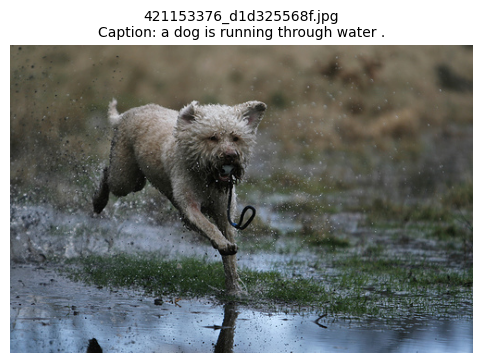

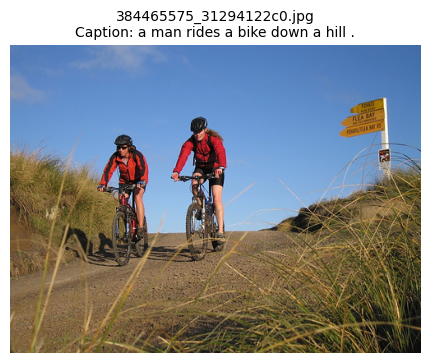

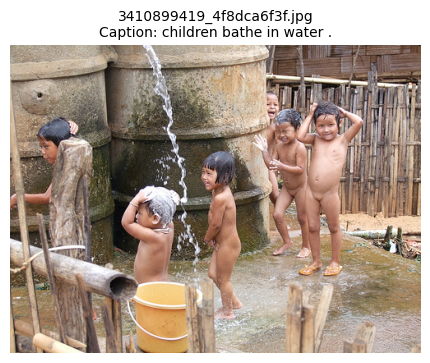

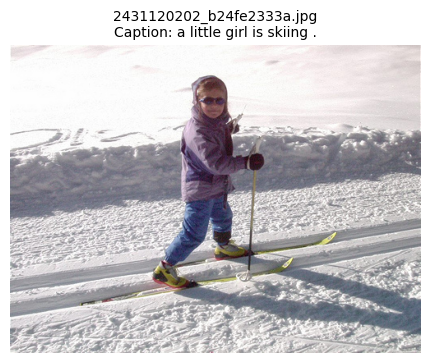

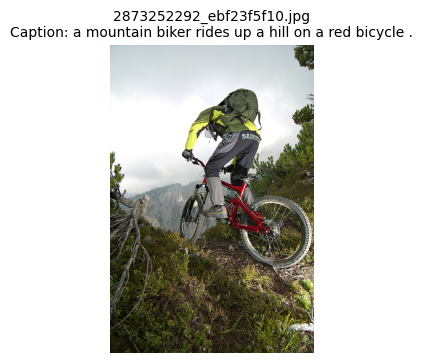

In [21]:
import json
import random
from pathlib import Path
import matplotlib.pyplot as plt
import cv2


BASE_DIR = Path("/kaggle/working/imgc") 
IMAGE_DIR = BASE_DIR / "data" / "Images"
CAPTIONS_FILE = BASE_DIR / "experiments" / "results" / "generated_captions.json"


if not IMAGE_DIR.exists():
    raise FileNotFoundError(f"❌ Images folder not found at {IMAGE_DIR}")
if not CAPTIONS_FILE.exists():
    raise FileNotFoundError(f"❌ Captions file not found at {CAPTIONS_FILE}")


with open(CAPTIONS_FILE, "r") as f:
    captions_dict = json.load(f)

# Pick random sample (5 images)
sample_images = random.sample(list(captions_dict.keys()), 5)


for img_name in sample_images:
    img_path = IMAGE_DIR / img_name
    caption = captions_dict[img_name]

    # Open with cv2
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Could not load {img_name}")
        continue

    # Convert BGR → RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.title(f"{img_name}\nCaption: {caption}", fontsize=10)
    plt.axis("off")
    plt.show()